## Summary
* In this tutorial, we will use apply a differentially private (DP) logistic regression model using the Tensorflow Privayc libray on the heart disease dataset.
* We will calculate the privacy guarantees provided by the DP model.
* We will complete a grid search to find hyperparameters that offer good privacy while maintaining an accceptable level of utility.

## Installs

References 



*   EDA: https://www.kaggle.com/cdabakoglu/heart-disease-classifications-machine-learning
*   TFP Code: https://github.com/tensorflow/privacy/tree/master/


In [1]:
# pip install tensorflow_privacy

In [9]:
from __future__ import absolute_import, division, print_function

import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow.compat.v1 as tf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow_privacy.privacy.analysis.rdp_accountant import (
    compute_rdp,
    get_privacy_spent,
)
from tensorflow_privacy.privacy.optimizers import dp_optimizer

## EDA and Preprocessing


The heart disese prediction dataset can be downloaded from [Kaggle](https://www.kaggle.com/ronitf/heart-disease-uci).

In [10]:
data_dir = "/ssd003/projects/pets/datasets"
df = pd.read_csv(f"{data_dir}/heart.csv")
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


Data contains: <br>

* age - age in years <br>
* sex - (1 = male; 0 = female) <br>
* cp - chest pain type <br>
* trestbps - resting blood pressure (in mm Hg on admission to the hospital) <br>
* chol - serum cholestoral in mg/dl <br>
* fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) <br>
* restecg - resting electrocardiographic results <br>
* thalach - maximum heart rate achieved <br>
* exang - exercise induced angina (1 = yes; 0 = no) <br>
* oldpeak - ST depression induced by exercise relative to rest <br>
* slope - the slope of the peak exercise ST segment <br>
* ca - number of major vessels (0-3) colored by flourosopy <br>
* thal - 3 = normal; 6 = fixed defect; 7 = reversable defect <br>
* target - have disease or not (1=yes, 0=no)

Percentage of Patients With No Heart Disease: 45.54%
Percentage of Patients With Heart Disease: 54.46%


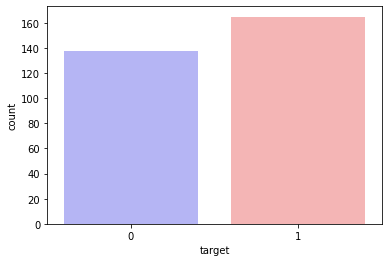

In [11]:
# Target
df.target.value_counts()
countNoDisease = len(df[df.target == 0])
countHaveDisease = len(df[df.target == 1])
print(
    "Percentage of Patients With No Heart Disease: {:.2f}%".format(
        (countNoDisease / (len(df.target)) * 100)
    )
)
print(
    "Percentage of Patients With Heart Disease: {:.2f}%".format(
        (countHaveDisease / (len(df.target)) * 100)
    )
)
sns.countplot(x="target", data=df, palette="bwr")
plt.show()

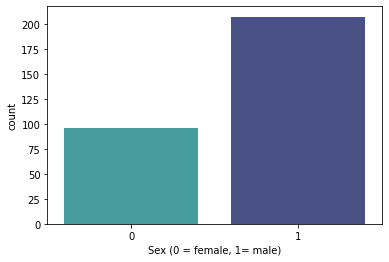

Percentage of Female Patients: 31.68%
Percentage of Male Patients: 68.32%


In [12]:
sns.countplot(x="sex", data=df, palette="mako_r")
plt.xlabel("Sex (0 = female, 1= male)")
plt.show()
countFemale = len(df[df.sex == 0])
countMale = len(df[df.sex == 1])
print(
    "Percentage of Female Patients: {:.2f}%".format((countFemale / (len(df.sex)) * 100))
)
print("Percentage of Male Patients: {:.2f}%".format((countMale / (len(df.sex)) * 100)))

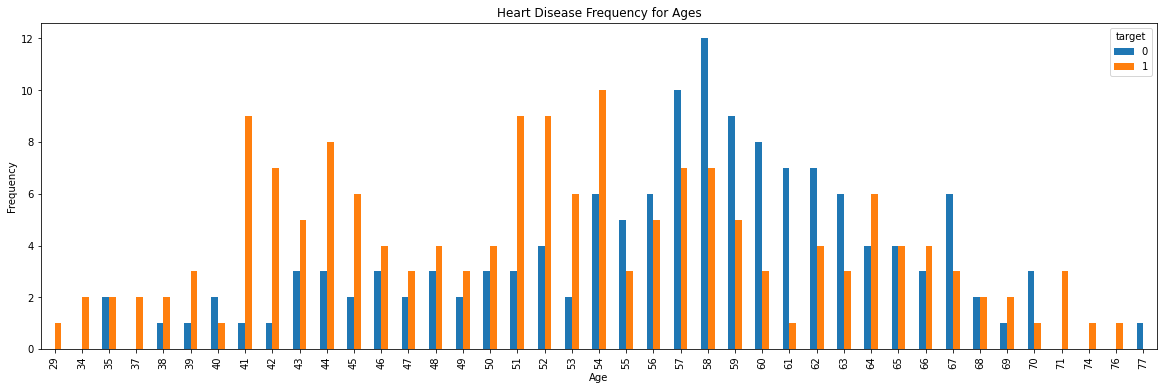

In [13]:
pd.crosstab(df.age, df.target).plot(kind="bar", figsize=(20, 6))
plt.title("Heart Disease Frequency for Ages")
plt.xlabel("Age")
plt.ylabel("Frequency")
# plt.savefig('heartDiseaseAndAges.png')
plt.show()

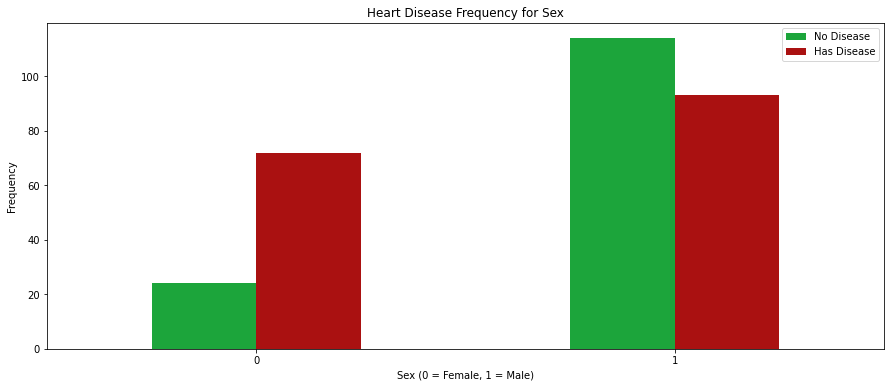

In [14]:
pd.crosstab(df.sex, df.target).plot(
    kind="bar", figsize=(15, 6), color=["#1CA53B", "#AA1111"]
)
plt.title("Heart Disease Frequency for Sex")
plt.xlabel("Sex (0 = Female, 1 = Male)")
plt.xticks(rotation=0)
plt.legend(["No Disease", "Has Disease"])
plt.ylabel("Frequency")
plt.show()

In [15]:
# one hot encode the categorical features
a = pd.get_dummies(df["cp"], prefix="cp")
b = pd.get_dummies(df["thal"], prefix="thal")
c = pd.get_dummies(df["slope"], prefix="slope")

In [16]:
frames = [df, a, b, c]
df = pd.concat(frames, axis=1)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,63,1,3,145,233,1,0,150,0,2.3,...,0,0,1,0,1,0,0,1,0,0
1,37,1,2,130,250,0,1,187,0,3.5,...,0,1,0,0,0,1,0,1,0,0
2,41,0,1,130,204,0,0,172,0,1.4,...,1,0,0,0,0,1,0,0,0,1
3,56,1,1,120,236,0,1,178,0,0.8,...,1,0,0,0,0,1,0,0,0,1
4,57,0,0,120,354,0,1,163,1,0.6,...,0,0,0,0,0,1,0,0,0,1


In [17]:
df = df.drop(columns=["cp", "thal", "slope"])
df.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,63,1,145,233,1,0,150,0,2.3,0,...,0,0,1,0,1,0,0,1,0,0
1,37,1,130,250,0,1,187,0,3.5,0,...,0,1,0,0,0,1,0,1,0,0
2,41,0,130,204,0,0,172,0,1.4,0,...,1,0,0,0,0,1,0,0,0,1
3,56,1,120,236,0,1,178,0,0.8,0,...,1,0,0,0,0,1,0,0,0,1
4,57,0,120,354,0,1,163,1,0.6,0,...,0,0,0,0,0,1,0,0,0,1


In [18]:
print("Data Sum of Null Values \n")
df.isnull().sum()

Data Sum of Null Values 



age         0
sex         0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
ca          0
target      0
cp_0        0
cp_1        0
cp_2        0
cp_3        0
thal_0      0
thal_1      0
thal_2      0
thal_3      0
slope_0     0
slope_1     0
slope_2     0
dtype: int64

In [19]:
y = df.target.values
x_data = df.drop(["target"], axis=1)

In [20]:
# min-max normalization
x = (x_data - np.min(x_data)) / (np.max(x_data) - np.min(x_data)).values

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [22]:
y_train

array([1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0])

In [15]:
x_train.shape

(242, 21)

In [23]:
training_size = x_train.shape[0]
training_size

242

## Logistic Regression Model

In [24]:
def lr_model_fn(
    features,
    labels,
    mode,
    nclasses,
    dim,
    regularizer,
    dpsgd,
    data_l2_norm,
    noise_multiplier,
    learning_rate,
):
    """Model function for logistic regression."""
    input_layer = tf.reshape(features["x"], tuple([-1]) + dim)
    logits = tf.keras.layers.Dense(
        units=nclasses,
        kernel_regularizer=tf.keras.regularizers.L2(l2=regularizer),
        bias_regularizer=tf.keras.regularizers.L2(l2=regularizer),
    ).apply(input_layer)

    # Calculate loss as a vector (to support microbatches in DP-SGD).
    vector_loss = (
        tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)
        + tf.losses.get_regularization_loss()
    )

    # Define mean of loss across minibatch (for reporting through tf.Estimator).
    scalar_loss = tf.reduce_mean(vector_loss)

    # Configure the training op (for TRAIN mode).
    if mode == tf.estimator.ModeKeys.TRAIN:

        if dpsgd:
            # The loss function is L-Lipschitz with L = sqrt(2*(||x||^2 + 1)) where
            # ||x|| is the norm of the data.
            # We don't use microbatches (thus speeding up computation), since no
            # clipping is necessary due to data normalization.
            optimizer = dp_optimizer.DPGradientDescentGaussianOptimizer(
                l2_norm_clip=math.sqrt(2 * (data_l2_norm ** 2 + 1)),
                noise_multiplier=noise_multiplier,
                num_microbatches=1,
                learning_rate=learning_rate,
            )
            opt_loss = vector_loss
        else:
            optimizer = GradientDescentOptimizer(learning_rate=learning_rate)
            opt_loss = scalar_loss
        global_step = tf.train.get_global_step()
        train_op = optimizer.minimize(loss=opt_loss, global_step=global_step)

        # In the following, we pass the mean of the loss (scalar_loss) rather than
        # the vector_loss because tf.estimator requires a scalar loss. This is only
        # used for evaluation and debugging by tf.estimator. The actual loss being
        # minimized is opt_loss defined above and passed to optimizer.minimize().
        return tf.estimator.EstimatorSpec(
            mode=mode, loss=scalar_loss, train_op=train_op
        )

    # Add evaluation metrics (for EVAL mode).
    elif mode == tf.estimator.ModeKeys.EVAL:
        eval_metric_ops = {
            "accuracy": tf.metrics.accuracy(
                labels=labels, predictions=tf.argmax(input=logits, axis=1)
            )
        }
        return tf.estimator.EstimatorSpec(
            mode=mode, loss=scalar_loss, eval_metric_ops=eval_metric_ops
        )

In [25]:
def normalize_data(data, data_l2_norm):
    """Normalizes data such that each samples has bounded L2 norm.

    Args:
      data: the dataset. Each row represents one samples.
      data_l2_norm: the target upper bound on the L2 norm.
    """
    for i in range(data.shape[0]):
        norm = np.linalg.norm(data[i])
        if norm > data_l2_norm:
            data[i] = data[i] / norm * data_l2_norm

    return data

In [31]:
def print_privacy_guarantees(epochs, batch_size, samples, noise_multiplier):
    """Tabulating position-dependent privacy guarantees."""
    if noise_multiplier == 0:
        print("No differential privacy (additive noise is 0).")
        return

    print(
        "In the conditions of Theorem 34 (https://arxiv.org/abs/1808.06651) "
        "the training procedure results in the following privacy guarantees."
    )

    print("Out of the total of {} samples:".format(samples))

    steps_per_epoch = samples // batch_size
    orders = np.concatenate([np.linspace(2, 20, num=181), np.linspace(20, 100, num=81)])
    delta = 1 / (samples * 1.1)
    for p in (0.5, 0.9, 0.99, 1.0):
        steps = math.ceil(steps_per_epoch * p)  # Steps in the last epoch.
        coef = (
            2
            * (noise_multiplier * batch_size) ** -2
            * (
                # Accounting for privacy loss
                (epochs - 1) / steps_per_epoch
                + 1 / (steps_per_epoch - steps + 1)  # ... from all-but-last epochs
            )
        )  # ... due to the last epoch
        # Using RDP accountant to compute eps. Doing computation analytically is
        # an option.
        rdp = [order * coef for order in orders]
        eps, _, _ = get_privacy_spent(orders, rdp, target_delta=delta)
        print("\t{:g}% enjoy at least ({:.2f}, {})-DP".format(p * 100, eps, delta))

    # Compute privacy guarantees for the Sampled Gaussian Mechanism.
    rdp_sgm = compute_rdp(
        batch_size / samples, noise_multiplier, epochs * steps_per_epoch, orders
    )
    eps_sgm, _, _ = get_privacy_spent(orders, rdp_sgm, target_delta=delta)
    print(
        "By comparison, DP-SGD analysis for training done with the same "
        "parameters and random shuffling in each epoch guarantees "
        "({:.2f}, {})-DP for all samples.".format(eps_sgm, delta)
    )

    return eps, delta

In [28]:
def train(
    noise_multiplier,
    batch_size,
    regularizer=0,
    data_l2_norm=8,
    dpsgd=True,
    learning_rate=0.01,
    epochs=120,
    model_dir=None,
    print_outputs=False,
):

    if data_l2_norm <= 0:
        raise ValueError("data_l2_norm must be positive.")
    if dpsgd and learning_rate > 8 / data_l2_norm ** 2:
        raise ValueError(
            "The amplification-by-iteration analysis requires"
            "learning_rate <= 2 / beta, where beta is the smoothness"
            "of the loss function and is upper bounded by ||x||^2 / 4"
            "with ||x|| being the largest L2 norm of the samples."
        )

    # Load training and test data.
    # Smoothness = ||x||^2 / 4 where ||x|| is the largest L2 norm of the samples.
    # To get bounded smoothness, we normalize the data such that each sample has a bounded L2 norm.
    train_data, test_data, train_labels, test_labels = train_test_split(
        x, y, test_size=0.2, random_state=0
    )

    train_data = train_data.to_numpy()
    test_data = test_data.to_numpy()
    train_data = normalize_data(train_data, data_l2_norm=data_l2_norm)
    test_data = normalize_data(test_data, data_l2_norm=data_l2_norm)

    # Instantiate tf.Estimator.
    # pylint: disable=g-long-lambda
    model_fn = lambda features, labels, mode: lr_model_fn(
        features,
        labels,
        mode,
        nclasses=2,
        dim=train_data.shape[1:],
        regularizer=regularizer,
        dpsgd=dpsgd,
        data_l2_norm=data_l2_norm,
        noise_multiplier=noise_multiplier,
        learning_rate=learning_rate,
    )
    mnist_classifier = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_dir)

    # Create tf.Estimator input functions for the training and test data.
    # To analyze the per-user privacy loss, we keep the same orders of samples in
    # each epoch by setting shuffle=False.
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": train_data},
        y=train_labels,
        batch_size=batch_size,
        num_epochs=epochs,
        shuffle=False,
    )
    valid_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": test_data}, y=test_labels, num_epochs=1, shuffle=False
    )

    # Train the model.
    num_samples = train_data.shape[0]
    steps_per_epoch = num_samples // batch_size

    mnist_classifier.train(input_fn=train_input_fn, steps=steps_per_epoch * epochs)

    # Evaluate the model and print results.
    train_results = mnist_classifier.evaluate(input_fn=train_input_fn)
    print(
        "Train accuracy after {} epochs is: {:.2f}".format(
            epochs, train_results["accuracy"]
        )
    )
    valid_results = mnist_classifier.evaluate(input_fn=valid_input_fn)
    print(
        "Test accuracy after {} epochs is: {:.2f}".format(
            epochs, valid_results["accuracy"]
        )
    )
    if dpsgd:
        eps_99, delta = print_privacy_guarantees(
            epochs=epochs,
            batch_size=batch_size,
            samples=num_samples,
            noise_multiplier=noise_multiplier,
        )

    return eps_99, delta, train_results["accuracy"], valid_results["accuracy"]

In [29]:
def train_grid_search(
    noise_multipliers,
    batch_sizes,
    data_l2_norms,
    regularizer=0,
    dpsgd=True,
    learning_rate=0.01,
    epochs=120,
    model_dir=None,
    print_outputs=False,
):

    table_outputs = []
    for batch_size in batch_sizes:
        for data_l2_norm in data_l2_norms:
            for noise_multiplier in noise_multipliers:
                eps, delta, train_accuracy, valid_accuracy = train(
                    noise_multiplier,
                    batch_size,
                    regularizer=regularizer,
                    data_l2_norm=data_l2_norm,
                    dpsgd=dpsgd,
                    learning_rate=learning_rate,
                    epochs=epochs,
                    model_dir=model_dir,
                    print_outputs=print_outputs,
                )

                table_outputs.append(
                    [
                        noise_multiplier,
                        batch_size,
                        regularizer,
                        data_l2_norm,
                        learning_rate,
                        epochs,
                        train_accuracy,
                        valid_accuracy,
                        eps,
                        delta,
                    ]
                )

    df = pd.DataFrame(
        table_outputs,
        columns=[
            "noise multiplier",
            "Batch size",
            "Regularizer",
            "Data L2 Norm",
            "learning rate",
            "Epochs",
            "Training accuracy",
            "Validation accuracy",
            "Epsilon",
            "Delta",
        ],
    )

    return df

In [37]:
GradientDescentOptimizer = tf.train.GradientDescentOptimizer

noise_multipliers = [1, 2, 3, 5]
data_l2_norms = [0.8, 1.0, 1.2]
batch_sizes = [11, 22, 242]

df = train_grid_search(
    noise_multipliers=noise_multipliers,
    batch_sizes=batch_sizes,
    regularizer=0,
    data_l2_norms=data_l2_norms,
    dpsgd=True,
    learning_rate=0.01,
    epochs=120,
    model_dir=None,
    print_outputs=False,
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp05t5q5mx', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initiali

/pkgs/jupyterhub/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp05t5q5mx/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.7815428, step = 0
INFO:tensorflow:global_step/sec: 532.242
INFO:tensorflow:loss = 0.67939913, step = 100 (0.188 sec)
INFO:tensorflow:global_step/sec: 867.615
INFO:tensorflow:loss = 0.71223855, step = 200 (0.115 sec)
INFO:tensorflow:global_step/sec: 889.23
INFO:tensorflow:loss = 0.6867052, step = 300 (0.113 sec)
INFO:tensorflow:global_step/sec: 914.932
INFO:tensorflow:loss = 0.7360174, step = 400 (0.109 sec)
INFO:tensorflow:global_step/sec: 891.724
INFO:tensorflow:loss = 0.5490538, step = 500 (0.114 sec)
INFO:tensorflow:global_step/sec: 898.84

INFO:tensorflow:global_step/sec: 927.699
INFO:tensorflow:loss = 0.40258047, step = 800 (0.108 sec)
INFO:tensorflow:global_step/sec: 935.149
INFO:tensorflow:loss = 0.5795004, step = 900 (0.107 sec)
INFO:tensorflow:global_step/sec: 922.135
INFO:tensorflow:loss = 0.47844908, step = 1000 (0.109 sec)
INFO:tensorflow:global_step/sec: 932.635
INFO:tensorflow:loss = 0.71170723, step = 1100 (0.107 sec)
INFO:tensorflow:global_step/sec: 916.425
INFO:tensorflow:loss = 0.7329247, step = 1200 (0.109 sec)
INFO:tensorflow:global_step/sec: 932.65
INFO:tensorflow:loss = 0.6007783, step = 1300 (0.107 sec)
INFO:tensorflow:global_step/sec: 937.981
INFO:tensorflow:loss = 0.48791313, step = 1400 (0.107 sec)
INFO:tensorflow:global_step/sec: 913.672
INFO:tensorflow:loss = 0.5666396, step = 1500 (0.110 sec)
INFO:tensorflow:global_step/sec: 926.095
INFO:tensorflow:loss = 0.22511382, step = 1600 (0.108 sec)
INFO:tensorflow:global_step/sec: 937.111
INFO:tensorflow:loss = 0.40177298, step = 1700 (0.107 sec)
INFO:te

INFO:tensorflow:Saving checkpoints for 2640 into /tmp/tmpsy1q7svd/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 2640...
INFO:tensorflow:Loss for final step: 0.614053.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-12-02T17:30:32
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpsy1q7svd/model.ckpt-2640
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 2.18630s
INFO:tensorflow:Finished evaluation at 2021-12-02-17:30:34
INFO:tensorflow:Saving dict for global step 2640: accuracy = 0.7933884, global_step = 2640, loss = 0.50982594
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2640: /tmp/tmpsy1q7svd/model.ckpt-2640
Train accuracy after 120 epochs is: 0.79
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 202

By comparison, DP-SGD analysis for training done with the same parameters and random shuffling in each epoch guarantees (1.24, 0.0037565740045078884)-DP for all samples.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmppov2mi1z', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_eval

INFO:tensorflow:global_step/sec: 933.796
INFO:tensorflow:loss = 1.0352582, step = 400 (0.106 sec)
INFO:tensorflow:global_step/sec: 953.03
INFO:tensorflow:loss = 1.0681359, step = 500 (0.105 sec)
INFO:tensorflow:global_step/sec: 981.994
INFO:tensorflow:loss = 0.7417362, step = 600 (0.102 sec)
INFO:tensorflow:global_step/sec: 945.131
INFO:tensorflow:loss = 1.1223464, step = 700 (0.106 sec)
INFO:tensorflow:global_step/sec: 930.383
INFO:tensorflow:loss = 1.2544514, step = 800 (0.107 sec)
INFO:tensorflow:global_step/sec: 944.08
INFO:tensorflow:loss = 1.3116848, step = 900 (0.106 sec)
INFO:tensorflow:global_step/sec: 934.553
INFO:tensorflow:loss = 1.0287952, step = 1000 (0.109 sec)
INFO:tensorflow:global_step/sec: 884.992
INFO:tensorflow:loss = 0.9375134, step = 1100 (0.111 sec)
INFO:tensorflow:global_step/sec: 953.873
INFO:tensorflow:loss = 0.6729526, step = 1200 (0.105 sec)
INFO:tensorflow:global_step/sec: 923.28
INFO:tensorflow:loss = 1.0252742, step = 1300 (0.108 sec)
INFO:tensorflow:glo

INFO:tensorflow:global_step/sec: 879.665
INFO:tensorflow:loss = 0.93195826, step = 2100 (0.115 sec)
INFO:tensorflow:global_step/sec: 875.155
INFO:tensorflow:loss = 1.4491137, step = 2200 (0.113 sec)
INFO:tensorflow:global_step/sec: 924
INFO:tensorflow:loss = 0.9019184, step = 2300 (0.108 sec)
INFO:tensorflow:global_step/sec: 893.885
INFO:tensorflow:loss = 0.6501555, step = 2400 (0.113 sec)
INFO:tensorflow:global_step/sec: 880.5
INFO:tensorflow:loss = 0.4866329, step = 2500 (0.112 sec)
INFO:tensorflow:global_step/sec: 950.01
INFO:tensorflow:loss = 1.1678303, step = 2600 (0.105 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 2640...
INFO:tensorflow:Saving checkpoints for 2640 into /tmp/tmp_vmmdzge/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 2640...
INFO:tensorflow:Loss for final step: 0.9451025.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-12-02T17:30:57

INFO:tensorflow:Saving dict for global step 2640: accuracy = 0.32786885, global_step = 2640, loss = 2.2171392
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2640: /tmp/tmpirv23jbh/model.ckpt-2640
Test accuracy after 120 epochs is: 0.33
In the conditions of Theorem 34 (https://arxiv.org/abs/1808.06651) the training procedure results in the following privacy guarantees.
Out of the total of 242 samples:
	50% enjoy at least (0.15, 0.0037565740045078884)-DP
	90% enjoy at least (0.15, 0.0037565740045078884)-DP
	99% enjoy at least (0.16, 0.0037565740045078884)-DP
	100% enjoy at least (0.16, 0.0037565740045078884)-DP
By comparison, DP-SGD analysis for training done with the same parameters and random shuffling in each epoch guarantees (1.24, 0.0037565740045078884)-DP for all samples.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpz9ekvv1d', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpx1w9mvi9/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.7679832, step = 0
INFO:tensorflow:global_step/sec: 556.801
INFO:tensorflow:loss = 0.62393576, step = 100 (0.182 sec)
INFO:tensorflow:global_step/sec: 890.724
INFO:tensorflow:loss = 0.55358595, step = 200 (0.111 sec)
INFO:tensorflow:global_step/sec: 882.309
INFO:tensorflow:loss = 0.32642338, step = 300 (0.113 sec)
INFO:tensorflow:global_step/sec: 837.598
INFO:tensorflow:loss = 1.1358167, step = 400 (0.119 sec)
INFO:tensorflow:global_step/sec: 934.558
INFO:tensorflow:loss = 0.43060446, step = 500 (0.107 sec)
INFO:tensorflow:global_step/sec: 912.23
INFO:tensorflow:loss = 0.458715, step = 600 (0.111 sec)
INFO:tensorflow:global_step/sec: 887.306
INFO:tensorflow:los

INFO:tensorflow:global_step/sec: 907.271
INFO:tensorflow:loss = 1.1035112, step = 1700 (0.110 sec)
INFO:tensorflow:global_step/sec: 908.836
INFO:tensorflow:loss = 0.7275286, step = 1800 (0.110 sec)
INFO:tensorflow:global_step/sec: 895.28
INFO:tensorflow:loss = 0.88385445, step = 1900 (0.112 sec)
INFO:tensorflow:global_step/sec: 876.925
INFO:tensorflow:loss = 0.7897934, step = 2000 (0.114 sec)
INFO:tensorflow:global_step/sec: 882.525
INFO:tensorflow:loss = 1.0468118, step = 2100 (0.113 sec)
INFO:tensorflow:global_step/sec: 913.654
INFO:tensorflow:loss = 0.57153153, step = 2200 (0.109 sec)
INFO:tensorflow:global_step/sec: 924.56
INFO:tensorflow:loss = 2.583433, step = 2300 (0.108 sec)
INFO:tensorflow:global_step/sec: 912.781
INFO:tensorflow:loss = 1.9007897, step = 2400 (0.110 sec)
INFO:tensorflow:global_step/sec: 916.225
INFO:tensorflow:loss = 1.7228905, step = 2500 (0.109 sec)
INFO:tensorflow:global_step/sec: 925.235
INFO:tensorflow:loss = 1.0195335, step = 2600 (0.108 sec)
INFO:tensor

INFO:tensorflow:Saving dict for global step 2640: accuracy = 0.71900827, global_step = 2640, loss = 1.6481214
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2640: /tmp/tmphxtyi7xn/model.ckpt-2640
Train accuracy after 120 epochs is: 0.72
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-12-02T17:31:30
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmphxtyi7xn/model.ckpt-2640
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.20539s
INFO:tensorflow:Finished evaluation at 2021-12-02-17:31:30
INFO:tensorflow:Saving dict for global step 2640: accuracy = 0.6885246, global_step = 2640, loss = 1.7297652
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2640: /tmp/tmphxtyi7xn/model.ckpt-2640
Test accuracy after 120 epochs is: 0.69
In the conditions of Theorem 34 (https://arxiv.org/abs/1808.0665

INFO:tensorflow:loss = 0.7126247, step = 300 (0.117 sec)
INFO:tensorflow:global_step/sec: 865.019
INFO:tensorflow:loss = 0.45849678, step = 400 (0.116 sec)
INFO:tensorflow:global_step/sec: 826.966
INFO:tensorflow:loss = 0.46783307, step = 500 (0.121 sec)
INFO:tensorflow:global_step/sec: 833.992
INFO:tensorflow:loss = 0.4964219, step = 600 (0.120 sec)
INFO:tensorflow:global_step/sec: 861.506
INFO:tensorflow:loss = 0.42943928, step = 700 (0.116 sec)
INFO:tensorflow:global_step/sec: 846.525
INFO:tensorflow:loss = 0.4660009, step = 800 (0.118 sec)
INFO:tensorflow:global_step/sec: 838.646
INFO:tensorflow:loss = 0.45288, step = 900 (0.119 sec)
INFO:tensorflow:global_step/sec: 821.263
INFO:tensorflow:loss = 0.40880445, step = 1000 (0.122 sec)
INFO:tensorflow:global_step/sec: 816.766
INFO:tensorflow:loss = 0.6591287, step = 1100 (0.122 sec)
INFO:tensorflow:global_step/sec: 827.901
INFO:tensorflow:loss = 0.45092487, step = 1200 (0.121 sec)
INFO:tensorflow:global_step/sec: 810.432
INFO:tensorflo

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpruc3cp43', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
IN

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 1.21568s
INFO:tensorflow:Finished evaluation at 2021-12-02-17:31:50
INFO:tensorflow:Saving dict for global step 1320: accuracy = 0.8016529, global_step = 1320, loss = 0.47785482
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1320: /tmp/tmplg9ej493/model.ckpt-1320
Train accuracy after 120 epochs is: 0.80
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-12-02T17:31:50
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmplg9ej493/model.ckpt-1320
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.20978s
INFO:tensorflow:Finished evaluation at 2021-12-02-17:31:50
INFO:tensorflow:Saving dict for global step 1320: accuracy = 0.852459, global_step = 1320, loss = 0.49147552
INFO:tensorflow:Saving '

INFO:tensorflow:loss = 0.8544041, step = 100 (0.187 sec)
INFO:tensorflow:global_step/sec: 847.807
INFO:tensorflow:loss = 0.8205185, step = 200 (0.118 sec)
INFO:tensorflow:global_step/sec: 851.606
INFO:tensorflow:loss = 0.74494195, step = 300 (0.117 sec)
INFO:tensorflow:global_step/sec: 809.325
INFO:tensorflow:loss = 0.8743324, step = 400 (0.125 sec)
INFO:tensorflow:global_step/sec: 798.328
INFO:tensorflow:loss = 1.0214125, step = 500 (0.124 sec)
INFO:tensorflow:global_step/sec: 853.446
INFO:tensorflow:loss = 2.0266683, step = 600 (0.117 sec)
INFO:tensorflow:global_step/sec: 858.788
INFO:tensorflow:loss = 1.5560784, step = 700 (0.117 sec)
INFO:tensorflow:global_step/sec: 804.292
INFO:tensorflow:loss = 0.9798631, step = 800 (0.126 sec)
INFO:tensorflow:global_step/sec: 805.658
INFO:tensorflow:loss = 0.803236, step = 900 (0.122 sec)
INFO:tensorflow:global_step/sec: 809.463
INFO:tensorflow:loss = 0.82194304, step = 1000 (0.125 sec)
INFO:tensorflow:global_step/sec: 877.692
INFO:tensorflow:lo

By comparison, DP-SGD analysis for training done with the same parameters and random shuffling in each epoch guarantees (1.89, 0.0037565740045078884)-DP for all samples.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpl8vwdnv1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_eval

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-12-02T17:32:09
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpeouzo761/model.ckpt-1320
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 1.21230s
INFO:tensorflow:Finished evaluation at 2021-12-02-17:32:10
INFO:tensorflow:Saving dict for global step 1320: accuracy = 0.61157024, global_step = 1320, loss = 0.7075351
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1320: /tmp/tmpeouzo761/model.ckpt-1320
Train accuracy after 120 epochs is: 0.61
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-12-02T17:32:10
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpeouzo761/model.ckpt-1320
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local

INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpg677pqml/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.6192572, step = 0
INFO:tensorflow:global_step/sec: 536.876
INFO:tensorflow:loss = 0.59780174, step = 100 (0.186 sec)
INFO:tensorflow:global_step/sec: 862.358
INFO:tensorflow:loss = 1.0000612, step = 200 (0.117 sec)
INFO:tensorflow:global_step/sec: 854.451
INFO:tensorflow:loss = 0.8101824, step = 300 (0.116 sec)
INFO:tensorflow:global_step/sec: 796.524
INFO:tensorflow:loss = 1.1984683, step = 400 (0.126 sec)
INFO:tensorflow:global_step/sec: 802.555
INFO:tensorflow:loss = 1.2015322, step = 500 (0.124 sec)
INFO:tensorflow:global_step/sec: 829.358
INFO:tensorflow:loss = 3.01327, step = 600 (0.122 sec)
INFO:tensorflow:global_step/sec: 833.664
INFO:tensorflow:loss = 1.6649686, step = 700 (0.120 sec)
INFO:tensorflow:global_step/sec: 772.81
INFO:tensorflow:loss = 1.4045056, step = 800 (0.128 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpshtiomij/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.70129585, step = 0
INFO:tensorflow:global_step/sec: 387.078
INFO:tensorflow:loss = 0.7792626, step = 100 (0.259 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 120...
INFO:tensorflow:Saving checkpoints for 120 into /tmp/tmpshtiomij/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 120...
INFO:tensorflow:Loss for final step: 0.83226454.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-1

INFO:tensorflow:Saving checkpoints for 120 into /tmp/tmpc1bzr3vk/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 120...
INFO:tensorflow:Loss for final step: 0.709069.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-12-02T17:32:25
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpc1bzr3vk/model.ckpt-120
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.41323s
INFO:tensorflow:Finished evaluation at 2021-12-02-17:32:25
INFO:tensorflow:Saving dict for global step 120: accuracy = 0.60330576, global_step = 120, loss = 0.6691443
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 120: /tmp/tmpc1bzr3vk/model.ckpt-120
Train accuracy after 120 epochs is: 0.60
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-12-02

INFO:tensorflow:Saving dict for global step 120: accuracy = 0.57024795, global_step = 120, loss = 0.6919959
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 120: /tmp/tmpofbv29pu/model.ckpt-120
Train accuracy after 120 epochs is: 0.57
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-12-02T17:32:29
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpofbv29pu/model.ckpt-120
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.21210s
INFO:tensorflow:Finished evaluation at 2021-12-02-17:32:29
INFO:tensorflow:Saving dict for global step 120: accuracy = 0.4262295, global_step = 120, loss = 0.71473086
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 120: /tmp/tmpofbv29pu/model.ckpt-120
Test accuracy after 120 epochs is: 0.43
In the conditions of Theorem 34 (https://arxiv.org/abs/1808.06651) the t

INFO:tensorflow:Saving dict for global step 120: accuracy = 0.57377046, global_step = 120, loss = 0.8812681
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 120: /tmp/tmp0hzpntss/model.ckpt-120
Test accuracy after 120 epochs is: 0.57
In the conditions of Theorem 34 (https://arxiv.org/abs/1808.06651) the training procedure results in the following privacy guarantees.
Out of the total of 242 samples:
	50% enjoy at least (0.02, 0.0037565740045078884)-DP
	90% enjoy at least (0.02, 0.0037565740045078884)-DP
	99% enjoy at least (0.02, 0.0037565740045078884)-DP
	100% enjoy at least (0.02, 0.0037565740045078884)-DP
By comparison, DP-SGD analysis for training done with the same parameters and random shuffling in each epoch guarantees (8.58, 0.0037565740045078884)-DP for all samples.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpt7ov_loe', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_che

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmplk00ywkv', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
IN

In [23]:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.


Note in the table below, the Epsilon value is the epsilon enjoyed by 100% of the input value.

In [38]:
df.sort_values(by=["Validation accuracy", "Epsilon"], ascending=[False, True])

,noise multiplier,Batch size,Regularizer,Data L2 Norm,learning rate,Epochs,Training accuracy,Validation accuracy,Epsilon,Delta
16,1,22,0,1.0,0.01,120,0.801653,0.852459,0.744535,0.003757
4,1,11,0,1.0,0.01,120,0.793388,0.852459,1.193491,0.003757
15,5,22,0,0.8,0.01,120,0.731405,0.819672,0.098923,0.003757
8,1,11,0,1.2,0.01,120,0.760331,0.803279,1.193491,0.003757
1,2,11,0,0.8,0.01,120,0.677686,0.786885,0.512488,0.003757
3,5,11,0,0.8,0.01,120,0.760331,0.770492,0.163671,0.003757
2,3,11,0,0.8,0.01,120,0.793388,0.770492,0.311096,0.003757
13,2,22,0,0.8,0.01,120,0.793388,0.770492,0.318228,0.003757
5,2,11,0,1.0,0.01,120,0.727273,0.770492,0.512488,0.003757
19,5,22,0,1.0,0.01,120,0.706612,0.721311,0.098923,0.003757


In [36]:
tuple([-1]) +x.shape[1:]

(-1, 21)